# Building Hard-Parameter Sharing NeuralNet in Multi-Task Learning

In this tutorial, we will use the [UTK Face Dataset](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwij2dvrpND6AhVXgFYBHdmYBIQQFnoECA0QAQ&url=https%3A%2F%2Fsusanqq.github.io%2FUTKFace%2F&usg=AOvVaw2ZqJbw298ywh2_n_zwuru1). It's a classification dataset where each image has 3 labels: 
- gender (male or female)
- race (white, black, Asian, Indian, other)
- age (a continuous number)

![](images/tutorial-task.png)

## Dataset

The dataset is a set of images, and the names of the images give the labels. For example, the image `25_1_3_20170119171913200.jpg.chip.jpg` can be interpreted as follows:

![](images/25_1_3_20170119171913200.jpg.chip.jpg)

- 25 is the age
- 1 is the gender (0: male, 1: female)
- 3 is the race (0:White, 1:Black, 2:Asian, 3:Indian, 4:Other)

## Prepare TF Dataset

### Load image from raw data

In [1]:
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
import numpy as np
import os

data_dir = "UTKFace/"
image_height = 32
image_width = 32

def load_image(data_dir, image_height, image_width):
    """
        Load image from raw data
    """
    X = []
    Y = []
    for filepath in tqdm(Path(data_dir).glob("**/*.jpg"), total=len(os.listdir(data_dir))):
        filepath = str(filepath)
        filename = os.path.basename(filepath)

        # get label (list of tasks): [age, gender, race, timestamp]
        label = filename.split('.')[0].split('_')
        if len(label) != 4:
            continue
            
        # remove timestamp
        label = list(map(int, label[:3]))
        
        # resize image
        raw_image = tf.io.read_file(filepath)
        image = tf.image.decode_image(raw_image)
        image = tf.cast(tf.image.resize(image, [image_height, image_width]), tf.float32)
        
        X.append(image)
        Y.append(label)
        
    return np.array(X), np.array(Y)

In [2]:
# load image from raw
X, Y = load_image(data_dir, image_height, image_width)
print(X.shape, Y.shape)

100%|██████████| 23708/23708 [00:26<00:00, 902.94it/s] 


(23705, 32, 32, 3) (23705, 3)


### Save and load TFRecord function

In [3]:
def save_tfrecords(data, label, desfile):
    """
    Input:
        data: numpy array with shape (n_samples, height, width, channel)
        label: numpy array with shape (n_samples, n_tasks)
        desfile: tfrecords's filepath
    """
    with tf.io.TFRecordWriter(desfile) as writer:
        for i in range(len(data)):
            features = tf.train.Features(
                feature = {
                    "data":tf.train.Feature(bytes_list = tf.train.BytesList(value = [data[i].astype(np.float32).tobytes()])),
                    "label":tf.train.Feature(bytes_list = tf.train.BytesList(value = [label[i].astype(np.int32).tobytes()]))
                }
            )
            example = tf.train.Example(features = features)
            serialized = example.SerializeToString()
            writer.write(serialized)

In [4]:
def _parse_function(example_proto):
    """
        Retrieve tensor array from tensor bytes
    """
    features = {"data": tf.io.FixedLenFeature((), tf.string),
                "label": tf.io.FixedLenFeature((), tf.string)}
    parsed_features = tf.io.parse_single_example(example_proto, features)
    data = tf.io.decode_raw(parsed_features['data'], tf.float32) / 255.
    label = tf.io.decode_raw(parsed_features['label'], tf.int32)
    data = tf.reshape(data, [image_height, image_width, 3])
    return {'image': data}, {'age': [label[0]], 'gender': [label[1]], 'race': [label[2]]}

def load_tfrecords(srcfile, batch_size):
    """
        Load dataset from tfrecords's filepath
    """
    dataset = tf.data.TFRecordDataset(srcfile) # load tfrecord file
    dataset = dataset.map(_parse_function) # parse data into tensor
    dataset = dataset.batch(batch_size) # set batch_size
    return dataset

### Test

In [5]:
# save numpy to tfrecords
save_tfrecords(data=X, label=Y, desfile="data.tfr")

In [6]:
# Load tensor from tfrecords
dataset = load_tfrecords(srcfile="data.tfr", batch_size=128)
for batch in dataset:
    inputs, labels = batch
    print(inputs['image'].shape)
    print(len(labels))
    break

(128, 32, 32, 3)
3


## Build model

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

In [8]:
# Build the encoder model
# The encoder model takes the image as input and turns it into a 2048-dimensional feature vector.

input_shape = (image_height, image_width, 3)

def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    outputs = resnet(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs, name="mtl_encoder")
    return model

In [9]:
encoder = create_encoder()
encoder.summary()

Model: "mtl_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
Total params: 23,564,800
Trainable params: 23,519,360
Non-trainable params: 45,440
_________________________________________________________________


In [10]:
# Build hydraNet for multi-task learning

learning_rate = 0.01
hidden_units = 512

def create_hydraNet(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape, name='image')
    features = encoder(inputs)
    
    # age head
    age_features = layers.Dense(hidden_units, activation="relu")(features)
    age_outputs = layers.Dense(1, name='age')(age_features)
    
    # gender head
    gender_features = layers.Dense(hidden_units, activation="relu")(features)
    gender_outputs = layers.Dense(1, name='gender')(gender_features)
    
    # race head
    race_features = layers.Dense(hidden_units, activation="relu")(features)
    race_outputs = layers.Dense(5, name='race')(race_features)
    
    # build model
    model = keras.Model(inputs=inputs, outputs=[age_outputs, gender_outputs, race_outputs], name="mtl_net")
    
    # define loss
    loss = {
        "age": tf.keras.losses.MeanSquaredError(),
        "gender": tf.keras.losses.BinaryCrossentropy(from_logits=True),
        "race": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    }
    loss_weights = {"age": 1.0, "gender": 1.0, "race": 1.0}

    # monitor metric
    metrics = {
        "age": tf.keras.metrics.MeanSquaredError(),
        "gender": tf.keras.metrics.BinaryAccuracy(),
        "race": tf.keras.metrics.SparseCategoricalAccuracy()
    }
    
    # compile
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=loss,
        loss_weights=loss_weights,
        metrics=metrics
    )

    return model

Model: "mtl_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
mtl_encoder (Functional)        (None, 2048)         23564800    image[0][0]                      
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          1049088     mtl_encoder[0][0]                
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          1049088     mtl_encoder[0][0]                
____________________________________________________________________________________________

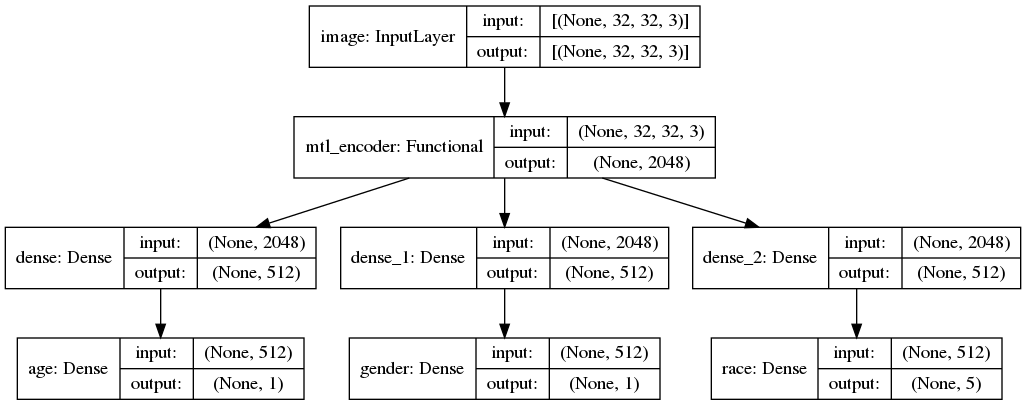

In [11]:
model = create_hydraNet(encoder)
model.summary()
tf.keras.utils.plot_model(model, to_file='hard_params_shared_model.png', show_shapes=True)

In [55]:
# training
model.fit(
    dataset,
    epochs=50
)

In [56]:
tf.keras.models.save_model(model, filepath="models")

INFO:tensorflow:Assets written to: models/assets


/home/hoang/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Inference

In [57]:
import matplotlib.pyplot as plt

In [58]:
model = tf.keras.models.load_model("models/")

(1, 32, 32, 3)
[[24.66038]] [[0.97508407]] [[0.12166625 0.7574938  0.00925702 0.07840184 0.03318099]]


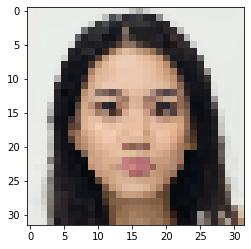

In [60]:
raw_image = tf.io.read_file("images/test.jpg")
image = tf.image.decode_image(raw_image)
image = tf.cast(tf.image.resize(image, [image_height, image_width]), tf.float32) / 255
plt.imshow(image)
image = tf.expand_dims(image, 0)
print(image.shape)

age, gender, race = model.predict(image)
gender = keras.activations.sigmoid(gender).numpy()
race = tf.nn.softmax(race).numpy()

print(age, gender, race)

(1, 32, 32, 3)
[[29.74011]] [[0.15337723]] [[0.29284006 0.01678104 0.3842911  0.17458135 0.13150643]]


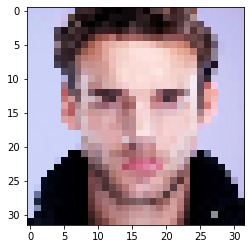

In [62]:
raw_image = tf.io.read_file("images/test_1.jpg")
image = tf.image.decode_image(raw_image)
image = tf.cast(tf.image.resize(image, [image_height, image_width]), tf.float32) / 255
plt.imshow(image)
image = tf.expand_dims(image, 0)
print(image.shape)

age, gender, race = model.predict(image)
gender = keras.activations.sigmoid(gender).numpy()
race = tf.nn.softmax(race).numpy()

print(age, gender, race)